# Transformer 구현 연습

### 혁팬하임 TTT 강의 수강 후  세미나 준비하며 개인 실습,

url : https://smartstore.naver.com/hyukppen/products/8258436602

In [ ]:
!pip install transformers
!pip install sentencepiece # MarianTokenizer 불러올 때 필요
!pip install matplotlib
!pip install einops
!pip install gdown

In [ ]:
!gdown https://drive.google.com/uc?id=1r4ZnFJOStyBlNRx7snBQ-Iq2GNyJKL6t -O '대화체.xlsx'

Downloading...
From: https://drive.google.com/uc?id=1r4ZnFJOStyBlNRx7snBQ-Iq2GNyJKL6t
To: /content/대화체.xlsx
100% 9.57M/9.57M [00:00<00:00, 20.1MB/s]


In [ ]:
import matplotlib.pyplot as plt

# touchs
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import pandas as pd

# 차원 변환
from einops import rearrange

# process 표시 용도
from tqdm import tqdm

# 연산
import math

# Tokenizer
from transformers import MarianTokenizer # MT: Machine Translation

DEVICE = "cuda" if torch.cuda.is_available() else "cpu" #gpu cuda 설정
print(DEVICE)

tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-ko-en')

cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/842k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

### Multi-Head Attention Model 구현

In [ ]:
class MHA(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()

        self.n_heads = n_heads

        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.fc_o = nn.Linear(d_model, d_model)

        self.scale = torch.sqrt(torch.tensor(d_model / n_heads)) # softmax 미분이 작어지는 것을 방지하기 위해

    def forward(self, Q, K, V, mask = None): # 순전파 (Query, Key, Value, mask: mask는 encoder에서 진행하지 않기 때문에 None을 defaults로)
        Q = self.fc_q(Q) # 관계를 물어볼 기준 단어 Vector
        K = self.fc_k(K) # Query와의 관계를 알아볼 단어 Vector
        V = self.fc_v(V) # Key 단어의 의미를 담은 Vector

        # 문장의 개수, 단어의 수, 임베딩 차원의 수, 헤드
        Q = einops.rearrange(Q, '개 단 (헤 차) -> 개 헤 단 차', 헤 = self.n_heads)
        K = einops.rearrange(K, '개 단 (헤 차) -> 개 헤 단 차', 헤 = self.n_heads)
        V = einops.rearrange(V, '개 단 (헤 차) -> 개 헤 단 차', 헤 = self.n_heads)

        attention_score = Q @ K.transpose(-2,-1)/self.scale # 개헤단단

        # masked attention
        if mask is not None:
            attention_score[mask] = -1e10

        attention_weights = torch.softmax(attention_score, dim=-1) # 개헤단단

        attention = attention_weights @ V # 개헤단차

        x = rearrange(attention, '개 헤 단 차 -> 개 단 (헤 차)') # 개헤단차 -> 개단차
        x = self.fc_o(x) # 개단차

        return x, attention_weights


class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, drop_p):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(d_model, d_ff),
                                    nn.ReLU(),
                                    nn.Dropout(drop_p), # 오버 피팅 방지
                                    nn.Linear(d_ff, d_model))

    def forward(self, x):
        x = self.linear(x)
        return x

In [ ]:
# Encoder
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.self_atten = MHA(d_model, n_heads)
        self.self_atten_LN = nn.LayerNorm(d_model)

        self.FF = FeedForward(d_model, d_ff, drop_p)
        self.FF_LN = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(drop_p)

    def forward(self, x, enc_mask):

        residual, atten_enc = self.self_atten(x, x, x, enc_mask)
        residual = self.dropout(residual)
        x = self.self_atten_LN(x + residual)

        residual = self.FF(x)
        residual = self.dropout(residual)
        x = self.FF_LN(x + residual)

        return x, atten_enc

class Encoder(nn.Module):
    def __init__(self, input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.scale = torch.sqrt(torch.tensor(d_model))
        self.input_embedding = input_embedding
        self.pos_embedding = nn.Embedding(max_len, d_model)

        self.dropout = nn.Dropout(drop_p)

        self.layers = nn.ModuleList([EncoderLayer(d_model, d_ff, n_heads, drop_p) for _ in range(n_layers)])

    def forward(self, src, mask, atten_map_save = False):

        pos = torch.arange(src.shape[1]).expand_as(src).to(DEVICE)

        x = self.scale*self.input_embedding(src) + self.pos_embedding(pos)
        x = self.dropout(x)

        atten_encs = torch.tensor([]).to(DEVICE)
        for layer in self.layers:
            x, atten_enc = layer(x, mask)
            if atten_map_save is True:
                atten_encs = torch.cat([atten_encs , atten_enc[0].unsqueeze(0)], dim=0)

        return x, atten_encs

### Decoder

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.self_atten = MHA(d_model, n_heads)
        self.self_atten_LN = nn.LayerNorm(d_model)

        self.enc_dec_atten = MHA(d_model, n_heads)
        self.enc_dec_atten_LN = nn.LayerNorm(d_model)

        self.FF = FeedForward(d_model, d_ff, drop_p)
        self.FF_LN = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(drop_p)

    def forward(self, x, enc_out, dec_mask, enc_dec_mask):

        residual, atten_dec = self.self_atten(x, x, x, dec_mask)
        residual = self.dropout(residual)
        x = self.self_atten_LN(x + residual)

        residual, atten_enc_dec = self.enc_dec_atten(x, enc_out, enc_out, enc_dec_mask) # Q는 Decoder, K, V는 Encoder
        residual = self.dropout(residual)
        x = self.enc_dec_atten_LN(x + residual)

        residual = self.FF(x)
        residual = self.dropout(residual)
        x = self.FF_LN(x + residual)

        return x, atten_dec, atten_enc_dec

class Decoder(nn.Module):
    def __init__(self, input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.scale = torch.sqrt(torch.tensor(d_model))
        self.input_embedding = input_embedding
        self.pos_embedding = nn.Embedding(max_len, d_model)

        self.dropout = nn.Dropout(drop_p)

        self.layers = nn.ModuleList([DecoderLayer(d_model, d_ff, n_heads, drop_p) for _ in range(n_layers)])

        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, trg, enc_out, dec_mask, enc_dec_mask, atten_map_save = False):

        pos = torch.arange(trg.shape[1]).expand_as(trg).to(DEVICE)

        x = self.scale*self.input_embedding(trg) + self.pos_embedding(pos)

        x = self.dropout(x)

        atten_decs = torch.tensor([]).to(DEVICE)
        atten_enc_decs = torch.tensor([]).to(DEVICE)
        for layer in self.layers:
            x, atten_dec, atten_enc_dec = layer(x, enc_out, dec_mask, enc_dec_mask)
            if atten_map_save is True:
                atten_decs = torch.cat([atten_decs , atten_dec[0].unsqueeze(0)], dim=0)
                atten_enc_decs = torch.cat([atten_enc_decs , atten_enc_dec[0].unsqueeze(0)], dim=0)

        x = self.fc_out(x)

        return x, atten_decs, atten_enc_decs

In [ ]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.input_embedding = nn.Embedding(vocab_size, d_model)
        self.encoder = Encoder(self.input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p)
        self.decoder = Decoder(self.input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p)

        self.n_heads = n_heads

        for m in self.modules():
            if hasattr(m,'weight') and m.weight.dim() > 1:
                nn.init.xavier_uniform_(m.weight)

    def make_enc_mask(self, src):

        enc_mask = (src == pad_idx).unsqueeze(1).unsqueeze(2)
        enc_mask = enc_mask.expand(src.shape[0], self.n_heads, src.shape[1], src.shape[1])

        return enc_mask

    def make_dec_mask(self, trg):

        trg_pad_mask = (trg == pad_idx).unsqueeze(1).unsqueeze(2)
        trg_pad_mask = trg_pad_mask.expand(trg.shape[0], self.n_heads, trg.shape[1], trg.shape[1])

        trg_future_mask = torch.tril(torch.ones(trg.shape[0], self.n_heads, trg.shape[1], trg.shape[1]))==0
        trg_future_mask = trg_future_mask.to(DEVICE)

        dec_mask = trg_pad_mask | trg_future_mask

        return dec_mask

    def make_enc_dec_mask(self, src, trg):

        enc_dec_mask = (src == pad_idx).unsqueeze(1).unsqueeze(2)
        enc_dec_mask = enc_dec_mask.expand(trg.shape[0], self.n_heads, trg.shape[1], src.shape[1])

        return enc_dec_mask

    def forward(self, src, trg):

        enc_mask = self.make_enc_mask(src)
        dec_mask = self.make_dec_mask(trg)
        enc_dec_mask = self.make_enc_dec_mask(src, trg)

        enc_out, atten_encs = self.encoder(src, enc_mask)
        out, atten_decs, atten_enc_decs = self.decoder(trg, enc_out, dec_mask, enc_dec_mask)

        return out, atten_encs, atten_decs, atten_enc_decs

In [ ]:
# 하이퍼 파라미터
LAMBDA = 0 # l2-Regularization를 위한 hyperparam. # 저장된 모델
max_len = 100 # 너무 길면 오래걸려서 짧게 설정
n_layers = 3
d_model = 256
d_ff = 512
n_heads = 8
drop_p = 0.1
vocab_size = tokenizer.vocab_size # 원래는 tokenizer의 vocab size를 가져와야하지만, 임의로 설정
eos_idx = tokenizer.eos_token_id
pad_idx = tokenizer.pad_token_id
warmup_steps = 1500
LR_scale = 0.5 # Noam scheduler에 peak LR 값 조절을 위해 곱할 것
BATCH_SIZE = 64
EPOCH = 15
LR_init = 5e-4
T0 = 1500 # 첫 주기
T_mult = 2 # 배 만큼 주기가 길어짐 (1보다 큰 정수)
scheduler_name = 'Noam'
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx) # pad token 이 출력 나와야하는 시점의 loss는 무시 (즉, label이 <pad> 일 때는 무시) # 저장된 모델


## 모델 생성

In [ ]:
model = Transformer(vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p).to(DEVICE)

src = torch.tensor([[4,6,5,1,1,1],[7,7,1,1,1,1]]).to(DEVICE)
trg = torch.tensor([[2,5,4,4,3,1,1],[2,9,6,7,3,1,1]]).to(DEVICE)

model.eval()
with torch.no_grad():
    x = model(src, trg)[0]
print(trg.shape)
print(x.shape)

torch.Size([2, 7])
torch.Size([2, 7, 65001])


In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data.loc[idx, '원문'], self.data.loc[idx, '번역문']

data = pd.read_excel('대화체.xlsx')
custom_DS = CustomDataset(data)

train_DS, val_DS, test_DS, _ = torch.utils.data.random_split(custom_DS, [95000, 2000, 1000, len(custom_DS)-95000-2000-1000])

train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_DS))
print(len(val_DS))
print(len(test_DS))

95000
2000
1000


## Train, Test, loss_epoch 함수

In [ ]:
def Train(model, train_DL, val_DL, criterion, optimizer, scheduler = None):
    loss_history = {"train": [], "val": []}
    best_loss = 9999
    for ep in range(EPOCH):
        model.train() # train mode로 전환
        train_loss = loss_epoch(model, train_DL, criterion, optimizer = optimizer, scheduler = scheduler)
        loss_history["train"] += [train_loss]

        model.eval() # test mode로 전환
        with torch.no_grad():
            val_loss = loss_epoch(model, val_DL, criterion)
            loss_history["val"] += [val_loss]
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save({"model": model,
                            "ep": ep,
                            "optimizer": optimizer,
                            "scheduler": scheduler,}, save_model_path)
        # print loss
        print(f"Epoch {ep+1}: train loss: {train_loss:.5f}   val loss: {val_loss:.5f}   current_LR: {optimizer.param_groups[0]['lr']:.8f}")
        print("-" * 20)

    torch.save({"loss_history": loss_history,
                "EPOCH": EPOCH,
                "BATCH_SIZE": BATCH_SIZE}, save_history_path)

def Test(model, test_DL, criterion):
    model.eval() # test mode로 전환
    with torch.no_grad():
        test_loss = loss_epoch(model, test_DL, criterion)
    print(f"Test loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}")

def loss_epoch(model, DL, criterion, optimizer = None, scheduler = None):
    N = len(DL.dataset) # the number of data

    rloss=0
    for src_texts, trg_texts in tqdm(DL, leave=False):
        src = tokenizer(src_texts, padding=True, truncation=True, max_length = max_len, return_tensors='pt').input_ids.to(DEVICE)
        trg_texts = ['</s> ' + s for s in trg_texts]
        trg = tokenizer(trg_texts, padding=True, truncation=True, max_length = max_len, return_tensors='pt').input_ids.to(DEVICE)
        # inference
        y_hat = model(src, trg[:,:-1])[0] # 모델 통과 시킬 땐 trg의 마지막 토큰은 제외!
        # y_hat.shape = 개단차 즉, 훈련 땐 문장이 한번에 튀어나옴
        # loss
        loss = criterion(y_hat.permute(0,2,1), trg[:,1:]) # loss 계산 시엔 <sos> 는 제외!
        """
        개단차 -> 개차단으로 바꿔줌 (1D segmentation으로 생각)
        개채행열(예측), 개행열(정답)으로 주거나 개채1열, 개1열로 주거나 개채열, 개열로 줘야하도록 함수를 만들어놔서
        우리 상황에서는 개차단, 개단 으로 줘야 한다.
        이렇게 함수를 만들어놔야 1D, 2D segmentation 등등으로 확장가능하기 때문
        다 필요없고, 그냥 y_hat=개차단, trg=개단으로 줘야만 계산 제대로 된다고 생각하시면 됩니다!
        """
        # update
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if scheduler is not None:
            scheduler.step()
        # loss accumulation
        loss_b = loss.item() * src.shape[0]
        rloss += loss_b
    loss_e = rloss/N
    return loss_e

def count_params(model):
    num = sum([p.numel() for p in model.parameters() if p.requires_grad])
    return num

class NoamScheduler:
    def __init__(self, optimizer, d_model, warmup_steps, LR_scale = 1):
        self.optimizer = optimizer
        self.current_step = 0
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.LR_scale = LR_scale

    def step(self):
        self.current_step += 1
        lrate = self.LR_scale * (self.d_model ** -0.5) * min(self.current_step ** -0.5, self.current_step * self.warmup_steps ** -1.5)
        self.optimizer.param_groups[0]['lr'] = lrate

def plot_scheduler(scheduler_name, optimizer, scheduler, total_steps): # LR curve 보기
    lr_history = []
    steps = range(1, total_steps)

    for _ in steps: # base model -> 10만 steps (12시간), big model -> 30만 steps (3.5일) 로 훈련했다고 함
        lr_history += [optimizer.param_groups[0]['lr']]
        scheduler.step()

    plt.figure()
    if scheduler_name == 'Noam':
        if total_steps == 100000:
            plt.plot(steps, (512 ** -0.5) * torch.tensor(steps) ** -0.5, 'g--', linewidth=1, label=r"$d_{\mathrm{model}}^{-0.5} \cdot \mathrm{step}^{-0.5}$")
            plt.plot(steps, (512 ** -0.5) * torch.tensor(steps) * 4000 ** -1.5, 'r--', linewidth=1, label=r"$d_{\mathrm{model}}^{-0.5} \cdot \mathrm{step} \cdot \mathrm{warmup\_steps}^{-1.5}$")
        plt.plot(steps, lr_history, 'b', linewidth=2, alpha=0.8, label="Learning Rate")
    elif scheduler_name == 'Cos':
        plt.plot(steps, lr_history, 'b', linewidth=2, alpha=0.8, label="Learning Rate")
    plt.ylim([-0.1*max(lr_history), 1.2*max(lr_history)])
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.grid()
    plt.legend()
    plt.show()

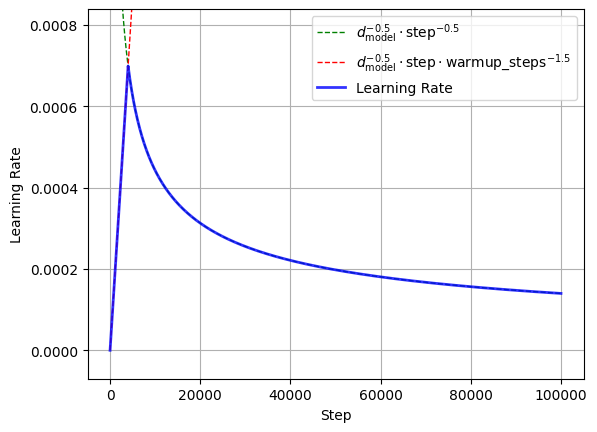

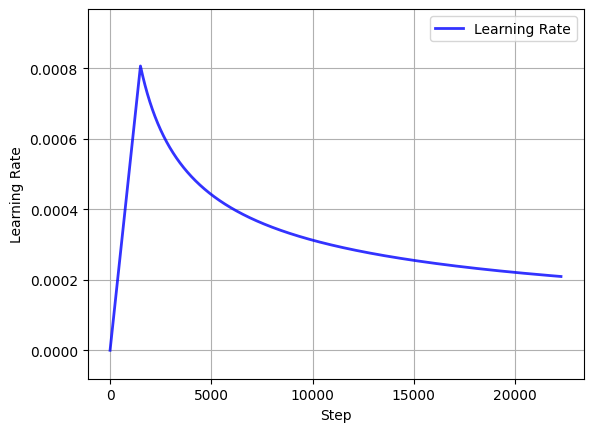

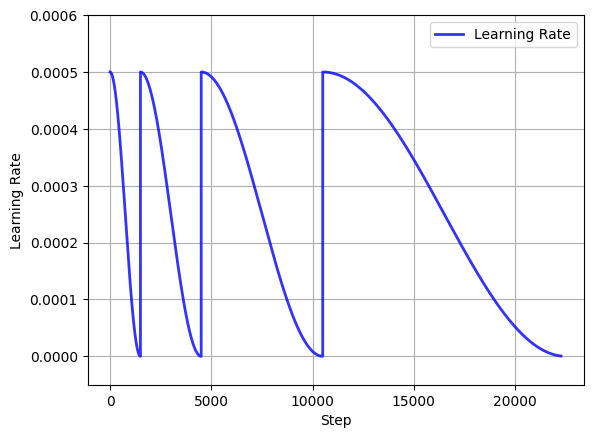

In [ ]:
optimizer = optim.Adam(nn.Linear(1, 1).parameters(), lr=0) # 테스트용 optimizer
scheduler = NoamScheduler(optimizer, d_model=512, warmup_steps=4000) # 논문 값
plot_scheduler(scheduler_name = 'Noam', optimizer = optimizer, scheduler = scheduler, total_steps = 100000)

optimizer = optim.Adam(nn.Linear(1, 1).parameters(), lr=0)
scheduler = NoamScheduler(optimizer, d_model=d_model, warmup_steps=warmup_steps, LR_scale=LR_scale)
plot_scheduler(scheduler_name = 'Noam', optimizer = optimizer, scheduler = scheduler, total_steps = int(len(train_DS)*EPOCH/BATCH_SIZE)) # 내 상황

optimizer = optim.Adam(nn.Linear(1, 1).parameters(), lr=LR_init)
scheduler = CosineAnnealingWarmRestarts(optimizer, T0, T_mult)
plot_scheduler(scheduler_name = 'Cos', optimizer = optimizer, scheduler = scheduler, total_steps = int(len(train_DS)*EPOCH/BATCH_SIZE))

## 모델 학습

In [ ]:
save_model_path = '/content/drive/MyDrive/Colab Notebooks/results/Transformer_small2.pt'
save_history_path = '/content/drive/MyDrive/Colab Notebooks/results/Transformer_small2_history.pt'
params = [p for p in model.parameters() if p.requires_grad] # 사전 학습된 layer를 사용할 경우
if scheduler_name == 'Noam':
  optimizer = optim.Adam(params, lr=0,
                         betas=(0.9, 0.98), eps=1e-9,
                         weight_decay=LAMBDA) # 논문에서 제시한 beta와 eps 사용, l2-Regularization은 한번 써봄 & 맨 처음 step 의 LR=0으로 출발 (warm-up)
  scheduler = NoamScheduler(optimizer, d_model=d_model, warmup_steps=warmup_steps, LR_scale=LR_scale)

elif scheduler_name == 'Cos':
  optimizer = optim.Adam(params, lr=LR_init,  # cos restart sheduling
                         betas=(0.9, 0.98), eps=1e-9,
                         weight_decay=LAMBDA)
  scheduler = CosineAnnealingWarmRestarts(optimizer, T0, T_mult)

  Train(model, train_DL, val_DL, criterion, optimizer, scheduler)